## Classifying NFL positions using RandomForest with a comparison to KMeans


In [1]:
# Import dependencies

import nfl_data_py as nfl

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report


### Import data

In [2]:
# Set range of years to sample data for
years = list(np.arange(2019,2023))

In [3]:
# Import data from nfl_data_py library
weekly = nfl.import_weekly_data(years)
print(f"There are {len(weekly)} records in the years {years}")

Downcasting floats.
There are 22035 records in the years [2019, 2020, 2021, 2022]


In [4]:
## Check column names if needed
# nfl.see_weekly_cols()

In [5]:
# Store names of numeric fields in a variable
quant_cols = ['completions', 'attempts', 'passing_yards',
       'passing_tds', 'interceptions', 'sacks', 'sack_yards', 'sack_fumbles',
       'sack_fumbles_lost', 'passing_air_yards', 'passing_yards_after_catch',
       'passing_first_downs', 'passing_epa', 'passing_2pt_conversions', 'pacr',
       'carries', 'rushing_yards', 'rushing_tds', 'rushing_fumbles',
       'rushing_fumbles_lost', 'rushing_first_downs', 'rushing_epa',
       'rushing_2pt_conversions', 'receptions', 'targets', 'receiving_yards',
       'receiving_tds', 'receiving_fumbles', 'receiving_fumbles_lost',
       'receiving_air_yards', 'receiving_yards_after_catch',
       'receiving_first_downs', 'receiving_epa', 'receiving_2pt_conversions',
       'racr', 'target_share', 'air_yards_share', 'wopr', 'special_teams_tds',
       'fantasy_points', 'fantasy_points_ppr']

# Reorganize data, dropping unnecessary columns (categoricals aside from grouping variables and position_group) 
# Group data as desired, e.g. by season for seasonal averages or by season and week to leave as weekly averages 
## ChatGPT consulted for getting rid of multi-level indices
# per chatgpt: reset_index() is used to restore the default integer-based index and move the current index (which could be a multi-level index) back into regular columns.

# grouped_by_season = weekly.groupby( ["season", "player_id", "position_group"])[quant_cols].median().reset_index()
grouped_by_week = weekly.groupby(["season", "week", "player_id", "position_group"])[quant_cols].median().reset_index()

print(f"There are {len(grouped_by_week)} records in the transformed dataset")

# Check for NAs
print("")
print("How many missing values are in the dataset (per column)?")
grouped_by_week.isna().sum()

There are 22035 records in the transformed dataset

How many missing values are in the dataset (per column)?


season                             0
week                               0
player_id                          0
position_group                     0
completions                        0
attempts                           0
passing_yards                      0
passing_tds                        0
interceptions                      0
sacks                              0
sack_yards                         0
sack_fumbles                       0
sack_fumbles_lost                  0
passing_air_yards                  0
passing_yards_after_catch          0
passing_first_downs                0
passing_epa                    19302
passing_2pt_conversions            0
pacr                           19344
carries                            0
rushing_yards                      0
rushing_tds                        0
rushing_fumbles                    0
rushing_fumbles_lost               0
rushing_first_downs                0
rushing_epa                    12865
rushing_2pt_conversions            0
r

### Clean data

In [6]:
##Data imputation for NaNs 

# Group the data by 'position_group' and calculate medians for the selected columns
# Medians used to avoid influence of outliers
medians = grouped_by_week.groupby('position_group')[quant_cols].transform('median')

# Replace missing values in the selected columns with corresponding medians
grouped_by_week[quant_cols] = grouped_by_week[quant_cols].fillna(medians)

print(f"There are now {grouped_by_week.isna().sum().sum()} missing values in the dataset.")

grouped_by_week.isna().sum()

There are now 131 missing values in the dataset.


season                          0
week                            0
player_id                       0
position_group                  0
completions                     0
attempts                        0
passing_yards                   0
passing_tds                     0
interceptions                   0
sacks                           0
sack_yards                      0
sack_fumbles                    0
sack_fumbles_lost               0
passing_air_yards               0
passing_yards_after_catch       0
passing_first_downs             0
passing_epa                    63
passing_2pt_conversions         0
pacr                           63
carries                         0
rushing_yards                   0
rushing_tds                     0
rushing_fumbles                 0
rushing_fumbles_lost            0
rushing_first_downs             0
rushing_epa                     5
rushing_2pt_conversions         0
receptions                      0
targets                         0
receiving_yard

In [7]:
grouped_by_week.head()

,season,week,player_id,position_group,completions,attempts,passing_yards,passing_tds,interceptions,sacks,...,receiving_first_downs,receiving_epa,receiving_2pt_conversions,racr,target_share,air_yards_share,wopr,special_teams_tds,fantasy_points,fantasy_points_ppr
0,2019,1,00-0019596,QB,24.0,36.0,341.0,3.0,0.0,1.0,...,0.0,-0.252246,0.0,0.000000,0.033333,0.001099,0.056924,0.0,25.639999,25.639999
1,2019,1,00-0020531,QB,32.0,43.0,370.0,2.0,1.0,1.0,...,0.0,-0.252246,0.0,0.000000,0.033333,0.001099,0.056924,0.0,20.799999,20.799999
2,2019,1,00-0022127,TE,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.060465,0.0,5.000000,0.125000,0.009967,0.194477,0.0,7.500000,10.500000
3,2019,1,00-0022803,QB,30.0,44.0,306.0,1.0,0.0,1.0,...,0.0,-0.252246,0.0,0.000000,0.033333,0.001099,0.056924,0.0,14.840000,14.840000
4,2019,1,00-0022921,WR,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,3.725990,0.0,0.738562,0.250000,0.283333,0.573333,0.0,17.299999,25.299999


In [8]:
# Note the dataset includes positions not relevant to our scope
grouped_by_week['position_group'].value_counts()

WR      8763
RB      6026
TE      4383
QB      2657
DB        75
SPEC      68
OL        38
LB        20
DL         5
Name: position_group, dtype: int64

In [9]:
# Make a copy of position column with False where a position is not in scope, and True where it is in scope of project
excluded_position_groups = ['DB', 'LB', 'OL', 'SPEC', 'DL']
mask = ~grouped_by_week['position_group'].isin(excluded_position_groups)
# Subset dataset to just entries with True
grouped_by_week = grouped_by_week[mask]

In [10]:
grouped_by_week['position_group'].value_counts()

WR    8763
RB    6026
TE    4383
QB    2657
Name: position_group, dtype: int64

In [11]:
print(f"There are now {grouped_by_week.isna().sum().sum()} missing values in the dataset.")
print("")
print(f"There are now {len(grouped_by_week)} rows in the dataset.")

There are now 0 missing values in the dataset.

There are now 21829 rows in the dataset.


### Supervise some learning

In [12]:
## ChatGPT was consulted for selecting a hyperparameter search tool appropriate to our dataset and classifier, 
## and for troubleshooting egregious runtimes

# Split the data into features, X, and the target variable, y
X = grouped_by_week[quant_cols]
y = grouped_by_week['position_group']

# Split the data into training and testing sets 
# Set a random_state value for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)


# Create a Random Forest Classifier
clf_search = RandomForestClassifier(random_state=40)

# Define a parameter grid to search through
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

random_search = RandomizedSearchCV(estimator=clf_search, param_distributions=param_dist, n_iter=10, cv=5)
random_search.fit(X_train, y_train)
best_params = random_search.best_params_

# Create a Random Forest Classifier with the identified hyperparameters
best_clf = RandomForestClassifier(random_state=40, **best_params)

# Train the model
best_clf.fit(X_train, y_train)

# Make predictions
y_pred = best_clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Print the results
print(f'Best Hyperparameters: {best_params}')
print(f'Accuracy: {accuracy}')
print('Classification Report:\n', report)

Best Hyperparameters: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 20}
Accuracy: 0.9993128721942282
Classification Report:
               precision    recall  f1-score   support

          QB       1.00      1.00      1.00       512
          RB       1.00      1.00      1.00      1197
          TE       1.00      1.00      1.00       852
          WR       1.00      1.00      1.00      1805

    accuracy                           1.00      4366
   macro avg       1.00      1.00      1.00      4366
weighted avg       1.00      1.00      1.00      4366



### Feature importance

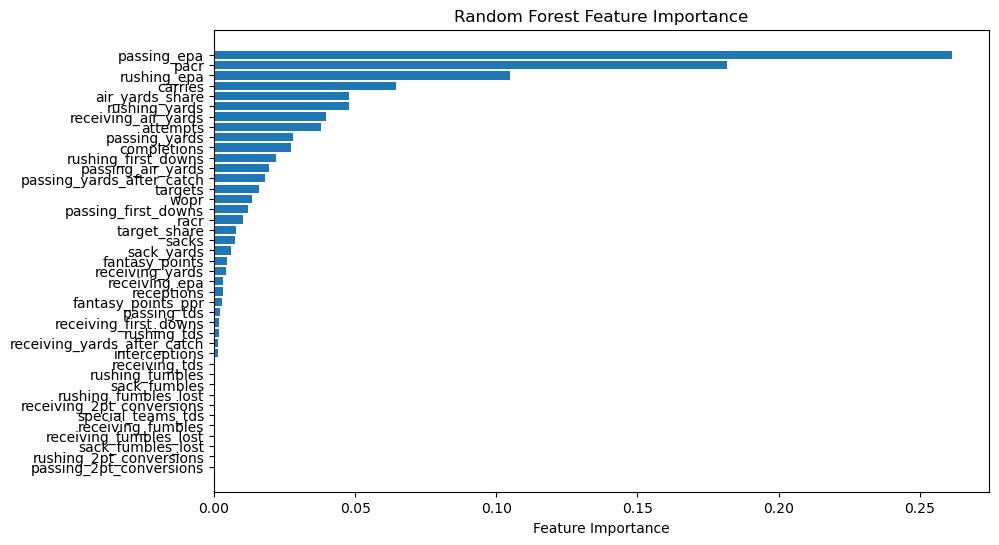

In [13]:
##ChatGPT was consulted for how to pull the feature importance data in correct order

feature_names = X.columns
feature_importance = best_clf.feature_importances_

# Sort feature importances in descending order
sorted_indices = np.argsort(feature_importance)[::-1]
sorted_feature_importance = feature_importance[sorted_indices]
sorted_feature_names = feature_names[sorted_indices]

# Create a bar plot for feature importances
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_feature_importance)), sorted_feature_importance, align='center')
plt.yticks(range(len(sorted_feature_importance)), sorted_feature_names)
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importance')
plt.gca().invert_yaxis()
plt.show()

C:\Users\timot\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


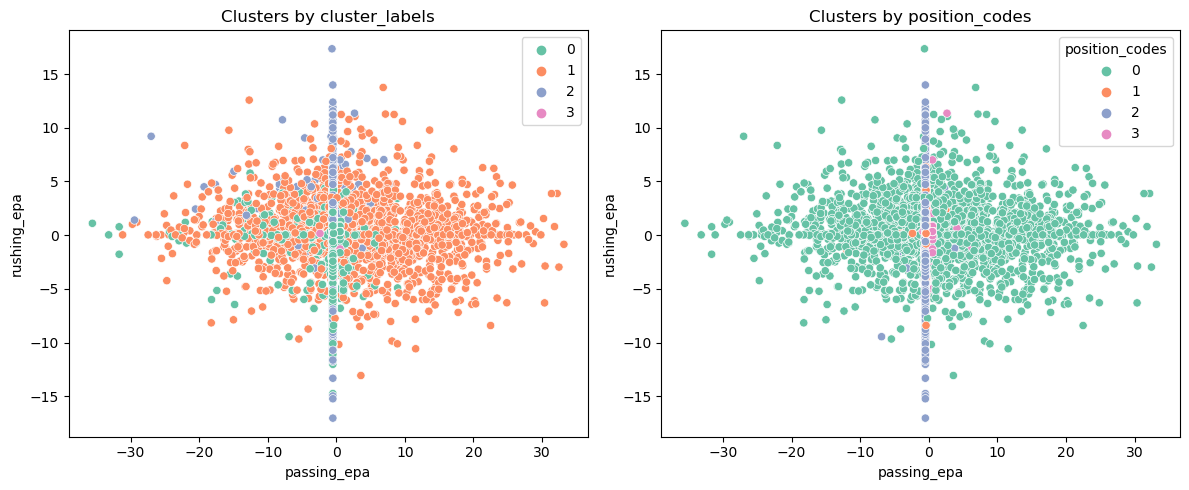

In [16]:
# Select the top n most important features (e.g., top 10)
n = 10
selected_feature_indices = sorted_indices[:n]

# Create a new dataframe with only the selected features
selected_features_df = X.iloc[:, selected_feature_indices]

# Apply K-Means clustering to the selected features
kmeans = KMeans(n_clusters=4, random_state=42)  
cluster_labels = kmeans.fit_predict(selected_features_df)

## Could color code plot by cluster label (since this is unsupervised learning) and/or actual position for a comparison
# Add the cluster labels back to the original dataframe
grouped_by_week['cluster_label'] = cluster_labels

# Use colors for the actual positions
# Define a mapping of categorical values to numeric values
position_mapping = {'QB': 0, 'WR': 1, 'RB': 2, 'TE': 3}
grouped_by_week['position_codes'] = grouped_by_week['position_group'].map(position_mapping)

# Visualize the clusters
## ChatGPT was consulted for using seaborn to make a multi-panel plot
# Create two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot the first graph with cluster_labels for color
sns.scatterplot(x=selected_features_df.iloc[:, 0], y=selected_features_df.iloc[:, 2], hue=cluster_labels, palette='Set2', ax=axes[0])
axes[0].set_title('Clusters by cluster_labels')

# Plot the second graph with position_codes for color
sns.scatterplot(x=selected_features_df.iloc[:, 0], y=selected_features_df.iloc[:, 2], hue=grouped_by_week['position_codes'], palette='Set2', ax=axes[1])
axes[1].set_title('Clusters by position_codes')

plt.tight_layout()
plt.show()




# plt.scatter(selected_features_df.iloc[:, 0], selected_features_df.iloc[:, 1], c=grouped_by_week['position_codes'], cmap='viridis')
# plt.xlabel('Feature 1')
# plt.ylabel('Feature 2')
# plt.title('K-Means Clustering')
# plt.show()